## Imports

In [168]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from collections import Counter
from google.colab import files

from tensorflow.keras.callbacks import Callback, CSVLogger, TensorBoard
from tensorflow.keras.applications import ResNet50, ResNet101, MobileNetV2, Xception, DenseNet121

from sklearn.metrics import accuracy_score, f1_score, hamming_loss, precision_score, recall_score, multilabel_confusion_matrix

import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import datetime
# %load_ext tensorboard

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## Data Processing

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Downloading file from Google Drive
download = drive.CreateFile({'id': '1hKFMGIY2jNYbntK4e4aGvwOwvzptP8DH'})
download.GetContentFile('data.tar.gz')

In [0]:
from data.data_utils import download_from_gdrive, load_data
download_from_gdrive()

In [0]:
!tar -xzvf data.tar.gz

In [174]:
cd ./data/keras

/content/data/keras/data/keras/data/keras/data/keras


In [0]:
def load_data(df):
    trainX, testX, valX = [], [], []
    trainY, testY, valY = [], [], []
    
    for i in range(len(df)):
        
        item = df.loc[i][0]
        current_label = np.array((df.loc[i])[1:])
        
        path = os.path.join('images', item)
        list_of_imgs = [os.path.join(path, file) for file in os.listdir(path)]
        train_set = list_of_imgs[:30]
        val_set = list_of_imgs[30:40]
        test_set = list_of_imgs[40:]
        
        for file in train_set:
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
            trainX.append(img)
            trainY.append(current_label)
        
        for file in val_set:
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
            valX.append(img)
            valY.append(current_label)
        
        for file in test_set:
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
            testX.append(img)
            testY.append(current_label)
    
    # Format arrays
    trainX, trainY = np.array(trainX, dtype=np.float32), np.array(trainY, dtype=np.int32)
    testX, testY = np.array(testX, dtype=np.float32), np.array(testY, dtype=np.int32)
    valX, valY = np.array(valX, dtype=np.float32), np.array(valY, dtype=np.int32)

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = trainX.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = trainX.std(axis=(0, 1, 2), keepdims=True)
    trainX = (trainX - mean_pixel) / std_pixel
    valX = (valX - mean_pixel) / std_pixel
    testX = (testX - mean_pixel) / std_pixel

    return (trainX, trainY, testX, testY, valX, valY)

In [0]:
df = pd.read_csv('clean_anno_reduced.csv')

In [0]:
raw_train_x, raw_train_y, raw_test_x, raw_test_y, raw_val_x, raw_val_y = load_data(df)
train = tf.data.Dataset.from_tensor_slices((raw_train_x, raw_train_y))
validation = tf.data.Dataset.from_tensor_slices((raw_val_x, raw_val_y))
test = tf.data.Dataset.from_tensor_slices((raw_test_x, raw_test_y))

<TensorSliceDataset shapes: ((224, 224, 3), (10,)), types: (tf.float32, tf.int32)>
<TensorSliceDataset shapes: ((224, 224, 3), (10,)), types: (tf.float32, tf.int32)>
<TensorSliceDataset shapes: ((224, 224, 3), (10,)), types: (tf.float32, tf.int32)>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


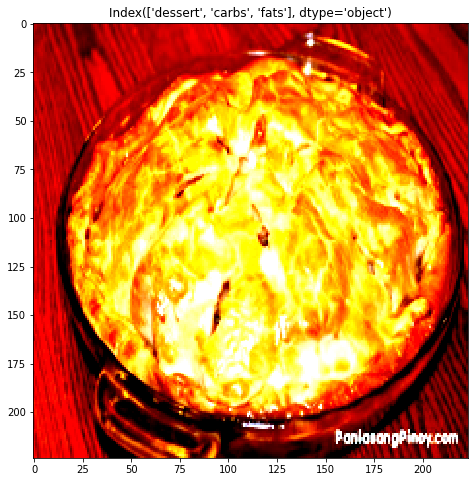

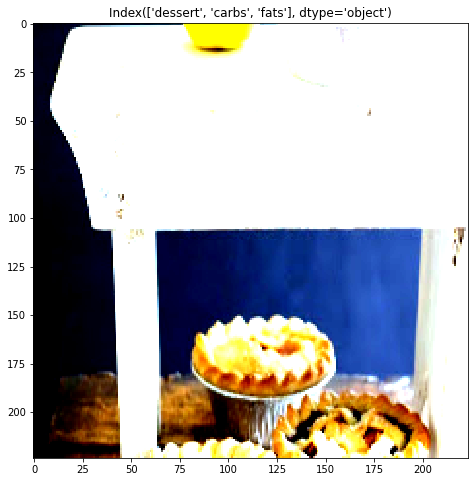

In [178]:
# Examine data
print(train)
print(validation)
print(test)

# get_label_name = metadata.features['label'].int2str
df_cols = df.columns[1:] # first col is samples
def get_label_name(label):
  return df_cols[label.numpy() == 1]

for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(str(get_label_name(label)))

In [0]:
# Shuffle and batch data
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [180]:
# Inspect batch
for image_batch, label_batch in train_batches.take(1):
   pass

print(image_batch.shape)

(32, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

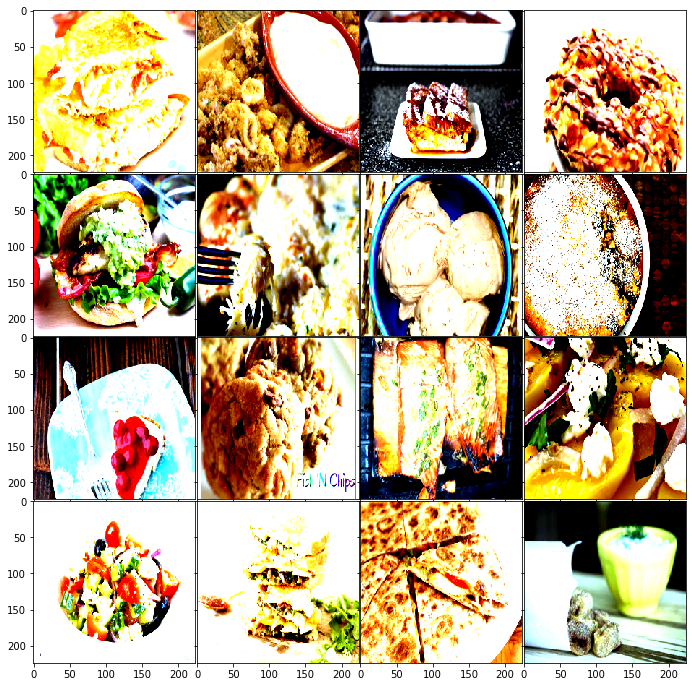

In [181]:
fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, rect=111, nrows_ncols=(4, 4))

for ax, i in zip(grid, range(16)):
  ax.imshow(image_batch[i])
  # ax.set_title(get_label_name(label_batch[i]), fontsize=8)

## Simple Model

In [0]:
# TODO: {data}, NUM_CLASSES, IMG_SHAPE = load_data() from .py script
# TODO: don't minibatch train, val data
device = '/cpu:0'
IMG_SHAPE = (224, 224, 3)

In [0]:
# Load SOTA models
base_MobileNet = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [184]:
base_MobileNet.trainable = False
base_MobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_37[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [185]:
# Define simple model
def simple_model(num_classes, base_model, input_shape=IMG_SHAPE):
  """ Base model - global pooling average - sigmoid activation architecture """
  initializer = tf.initializers.VarianceScaling(scale=2.0) # kaiming based
  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  predictions = tf.keras.layers.Dense(num_classes, activation='sigmoid',
                            kernel_initializer=initializer)(x)
  model = tf.keras.Model(inputs=inputs, outputs=predictions)
  return model

def test_functional_layers():
    """ A small unit test to exercise the custom model above. """
    input_size, num_classes = (64, 224, 224, 3), 10
    
    x = tf.zeros(input_size)
    model = simple_model(num_classes, base_ResNet101)
    
    with tf.device(device):
        scores = model(x)
        print(scores.shape)
        
test_functional_layers() # expect 64 samples, 10 scores each

(64, 10)


In [0]:
# Multilabel classification metrics from sklearn.metrics
def eval_as_np(fn, y_true, y_pred):
    return tf.numpy_function(fn, [y_true, tf.round(y_pred)], tf.double)

def accuracy_ml(y_true, y_pred):
  return eval_as_np(accuracy_score, y_true, y_pred)

def f1_score_macro(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

def f1_ml(y_true, y_pred):
  return eval_as_np(f1_score_macro, y_true, y_pred)

def hamming_ml(y_true, y_pred):
  return eval_as_np(hamming_loss, y_true, y_pred)

def prec_ml(y_true, y_pred):
  return eval_as_np(precision_score, y_true, y_pred)

def recall_ml(y_true, y_pred):
  return eval_as_np(recall_score, y_true, y_pred)

# Compile model
cnn = simple_model(num_classes=10,
                   base_model = base_MobileNet)

lr = 1e-2
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics = [accuracy_ml, f1_ml, hamming_ml]
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=loss_fn,
            metrics=metrics)
            
# cnn.summary()
# len(cnn.trainable_variables)

In [0]:
# Training parameters
initial_epochs = 30
validation_steps=17

# Callback for multilabel metrics from sklearn.metrics
class MetricsHistory(Callback):
  def __init__(self):
    self.best_f1 = -1
    
  def on_epoch_end(self, epoch, logs={}):
    val_f1 = logs['f1_ml']

    print('Validation performance')
    print('F1 score: ', val_f1)
    print('Accuracy: ', logs['accuracy_ml'])
    print('Hamming loss: ', logs['hamming_ml'])
    
    if val_f1 > self.best_f1:
      print("Better F1 score, saving model ...")
    self.model.save('simple_model.h5')
    self.best_f1 = val_f1

metrics_callback = MetricsHistory()

# All callbacks
callbacks = [
  metrics_callback,
  CSVLogger('logs/train_log.csv'),
  TensorBoard(log_dir='logs')
]

In [188]:
# Baseline accuracy
loss_0, acc_0, f1_0, hamming_0= cnn.evaluate(validation_batches, steps = validation_steps)
print("initial loss: {:.3f}".format(loss_0))
print("initial accuracy: {:.3f}".format(acc_0))
print("initial f1 score: {:.3f}".format(f1_0))
print("initial hamming loss: {:.3f}".format(hamming_0))

17/17 [==============================] - 17s 989ms/step - loss: 0.7100 - accuracy_ml: 0.0000e+00 - f1_ml: 0.2811 - hamming_ml: 0.4320
initial loss: 0.710
initial accuracy: 0.000
initial f1 score: 0.281
initial hamming loss: 0.432


In [0]:
# Monitor training
# %tensorboard --logdir logs/

In [190]:
# Train model
history = cnn.fit(train_batches, # TODO: decide batchsize here instead of pre-batching above?
                    epochs=initial_epochs,
                    # steps_per_epoch=10,
                    validation_data=validation_batches,
                    callbacks=callbacks)

Epoch 1/30
34/53 [==================>...........] - ETA: 19s - loss: 0.6314 - accuracy_ml: 0.0947 - f1_ml: 0.4827 - hamming_ml: 0.2677

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


53/53 [==============================] - ETA: 0s - loss: 0.5835 - accuracy_ml: 0.1089 - f1_ml: 0.5141 - hamming_ml: 0.2513Validation performance
F1 score:  0.514060378074646
Accuracy:  0.10888364911079407
Hamming loss:  0.25125783681869507
Better F1 score, saving model ...
53/53 [==============================] - 73s 1s/step - loss: 0.5835 - accuracy_ml: 0.1089 - f1_ml: 0.5141 - hamming_ml: 0.2513 - val_loss: 0.5208 - val_accuracy_ml: 0.1324 - val_f1_ml: 0.4853 - val_hamming_ml: 0.2353
Epoch 2/30
53/53 [==============================] - ETA: 0s - loss: 0.3911 - accuracy_ml: 0.2433 - f1_ml: 0.6774 - hamming_ml: 0.1741Validation performance
F1 score:  0.6774243116378784
Accuracy:  0.2433176040649414
Hamming loss:  0.17407624423503876
Better F1 score, saving model ...
53/53 [==============================] - 73s 1s/step - loss: 0.3911 - accuracy_ml: 0.2433 - f1_ml: 0.6774 - hamming_ml: 0.1741 - val_loss: 0.4986 - val_accuracy_ml: 0.2316 - val_f1_ml: 0.4442 - val_hamming_ml: 0.2035
Epoch 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


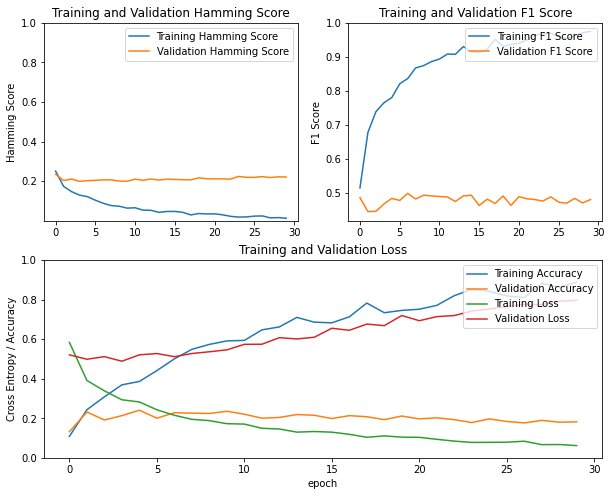

In [205]:
# Training results
acc = history.history['accuracy_ml']
val_acc = history.history['val_accuracy_ml']

loss = history.history['loss']
val_loss = history.history['val_loss']

hamming = history.history['hamming_ml']
val_hamming = history.history['val_hamming_ml']

f1 = history.history['f1_ml']
val_f1 = history.history['val_f1_ml']

plt.figure()
plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy / Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 2)
plt.plot(f1, label='Training F1 Score')
plt.plot(val_f1, label='Validation F1 Score')
plt.legend(loc='upper right')
plt.ylabel('F1 Score')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation F1 Score')

plt.subplot(2, 2, 1)
plt.plot(hamming, label='Training Hamming Score')
plt.plot(val_hamming, label='Validation Hamming Score')
plt.legend(loc='upper right')
plt.ylabel('Hamming Score')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Hamming Score')

plt.show()



In [0]:
# Save model weights
# TODO: upload model weights
files.download("simple_model.h5")

## Misclassification Analysis

In [0]:
# Examine confusion matrix
# TODO: diagnose predict steps, maybe by unbatching validation dataset
val_pred = cnn.predict(validation)
val_confusion_matrix = multilabel_confusion_matrix(val_pred, validation[1])

In [0]:
# Visualize by worst accuracy, then by ingredient
# TODO: Save {misclassified, accuracy} to csv
# TODO: setup visualizations